## Analyse Exploratoire des Données (EDA)

#### Générer des statistiques descriptives globales avec .describe().show().

In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Prédiction de l'Attrition Client Bancaire")
    .getOrCreate()
)


In [3]:
df = spark.read.csv("../data/raw/dataset.csv", header=True, inferSchema=True)

In [4]:
df.describe().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

#### Identifier les valeurs manquantes par colonne via df.select.

In [5]:
from pyspark.sql import functions as F

cols = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]

df_with_nulls = df.select(cols)
df_with_nulls.show()

+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



DataFrame ne contient pas des valeurs manquantes

#### Détecter les outliers via la méthode des quantiles approximatifs (approxQuantile) ou IQR.

- ApproxQuantitle

In [6]:

for col in ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']:
    Q1, Q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.filter((df[col] < lower_bound) | (df[col] > upper_bound))
    print(f"{col :20s} - {outliers.count()}")



CustomerId           - 0
CreditScore          - 17
Age                  - 359
Tenure               - 0
Balance              - 0
NumOfProducts        - 60
EstimatedSalary      - 0


#### Effectuer une analyse groupée avec groupBy() et des agrégations (agg, count, avg, sql, etc.).

- Group by Geography

In [7]:
from pyspark.sql import functions as F

df.groupBy("Geography").agg(
    F.sum("CreditScore").alias("Sum_CreditScore"),
    F.round(F.sum("Balance"), 2).alias("Sum_Balance"),
    F.sum("NumOfProducts").alias("Sum_NumOfProducts"),
    F.round(F.avg("Age"), 2).alias("avg_Age")
).show()

+---------+---------------+--------------+-----------------+-------+
|Geography|Sum_CreditScore|   Sum_Balance|Sum_NumOfProducts|avg_Age|
+---------+---------------+--------------+-----------------+-------+
|  Germany|        1634497|3.0040286138E8|             3813|  39.77|
|   France|        3257437|3.1133247949E8|             7676|  38.51|
|    Spain|        1613354|1.5312355201E8|             3813|  38.89|
+---------+---------------+--------------+-----------------+-------+



- Group by Age

In [8]:
from pyspark.sql import functions as F

df.groupBy("Age").agg(
    F.round(F.avg("CreditScore")).alias("Avg_CreditScore"),
    F.round(F.avg("Balance"), 2).alias("Avg_Balance"),
    F.round(F.avg("NumOfProducts")).alias("Avg_NumOfProducts"),
    F.sum("NumOfProducts").alias("Sum_NumOfProducts"),
).orderBy("Age").show(100)

+---+---------------+-----------+-----------------+-----------------+
|Age|Avg_CreditScore|Avg_Balance|Avg_NumOfProducts|Sum_NumOfProducts|
+---+---------------+-----------+-----------------+-----------------+
| 18|          687.0|   79169.58|              2.0|               33|
| 19|          666.0|   70502.54|              1.0|               37|
| 20|          665.0|   76038.89|              2.0|               62|
| 21|          647.0|   75926.88|              2.0|               88|
| 22|          637.0|   68213.75|              2.0|              128|
| 23|          658.0|   78528.57|              2.0|              151|
| 24|          654.0|   72824.28|              2.0|              199|
| 25|          643.0|   78282.26|              2.0|              249|
| 26|          649.0|   79573.75|              2.0|              303|
| 27|          643.0|   72536.15|              2.0|              328|
| 28|          657.0|   73159.74|              2.0|              436|
| 29|          653.0

#### Group by Gender

In [9]:
from pyspark.sql import functions as F

df.groupBy("Gender").agg(
    F.round(F.avg("CreditScore")).alias("Avg_CreditScore"),
    F.round(F.avg("Balance"), 2).alias("Avg_Balance"),
    F.round(F.avg("Age")).alias("Avg_Age"),
    F.round(F.avg("NumOfProducts")).alias("Avg_NumOfProducts"),
    F.sum("NumOfProducts").alias("Sum_NumOfProducts"),
).show()

+------+---------------+-----------+-------+-----------------+-----------------+
|Gender|Avg_CreditScore|Avg_Balance|Avg_Age|Avg_NumOfProducts|Sum_NumOfProducts|
+------+---------------+-----------+-------+-----------------+-----------------+
|Female|          651.0|   75659.37|   39.0|              2.0|             7015|
|  Male|          650.0|   77173.97|   39.0|              2.0|             8287|
+------+---------------+-----------+-------+-----------------+-----------------+



#### Visualisation de données

- Histogrammes

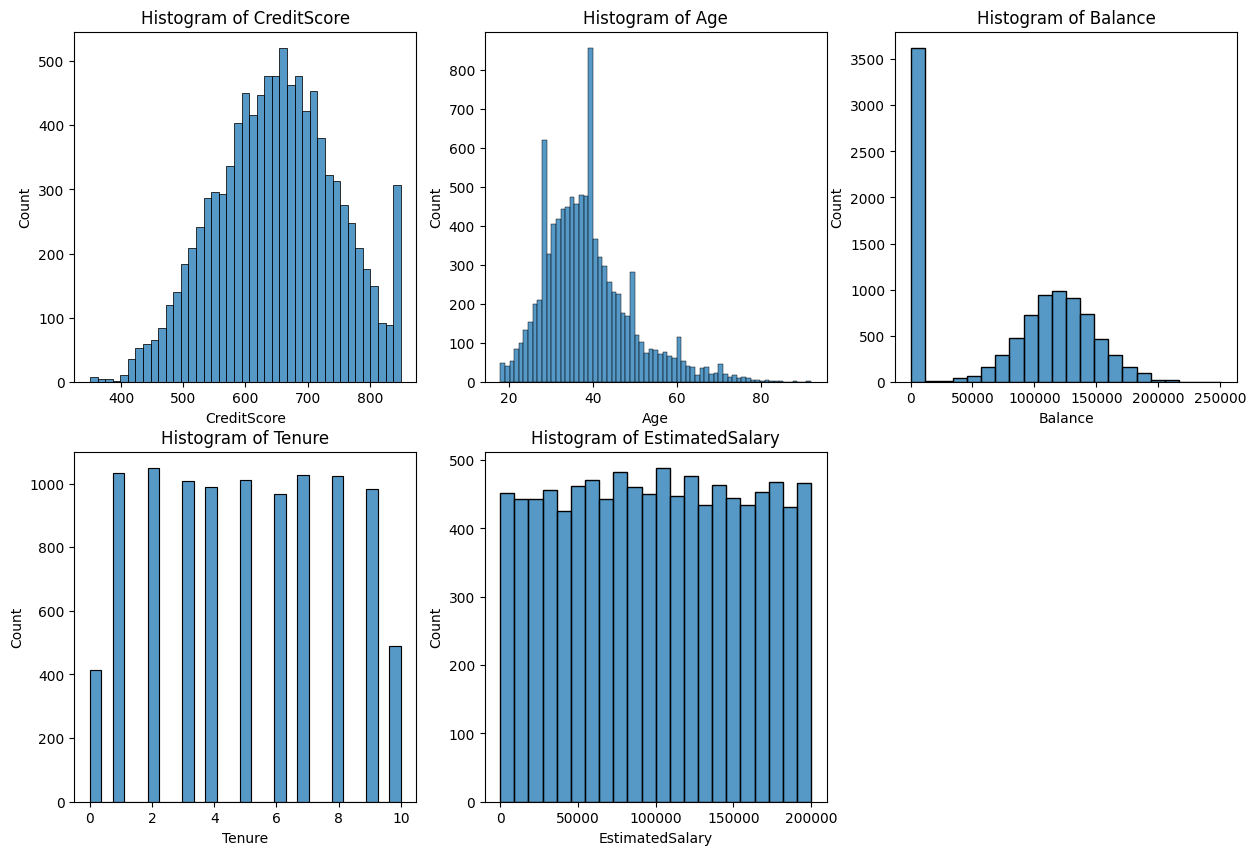

In [12]:
import matplotlib.pyplot as plt
import seaborn as sb

pdf = df.toPandas()

i = 1

plt.figure(figsize=(15,10))

for c in ["CreditScore", "Age", "Balance", "Tenure", "EstimatedSalary"]:

    plt.subplot(2, 3, i)
    sb.histplot(pdf[c])
    plt.title("Histogram of " + c)

    i += 1

plt.show()


- Pie Chart

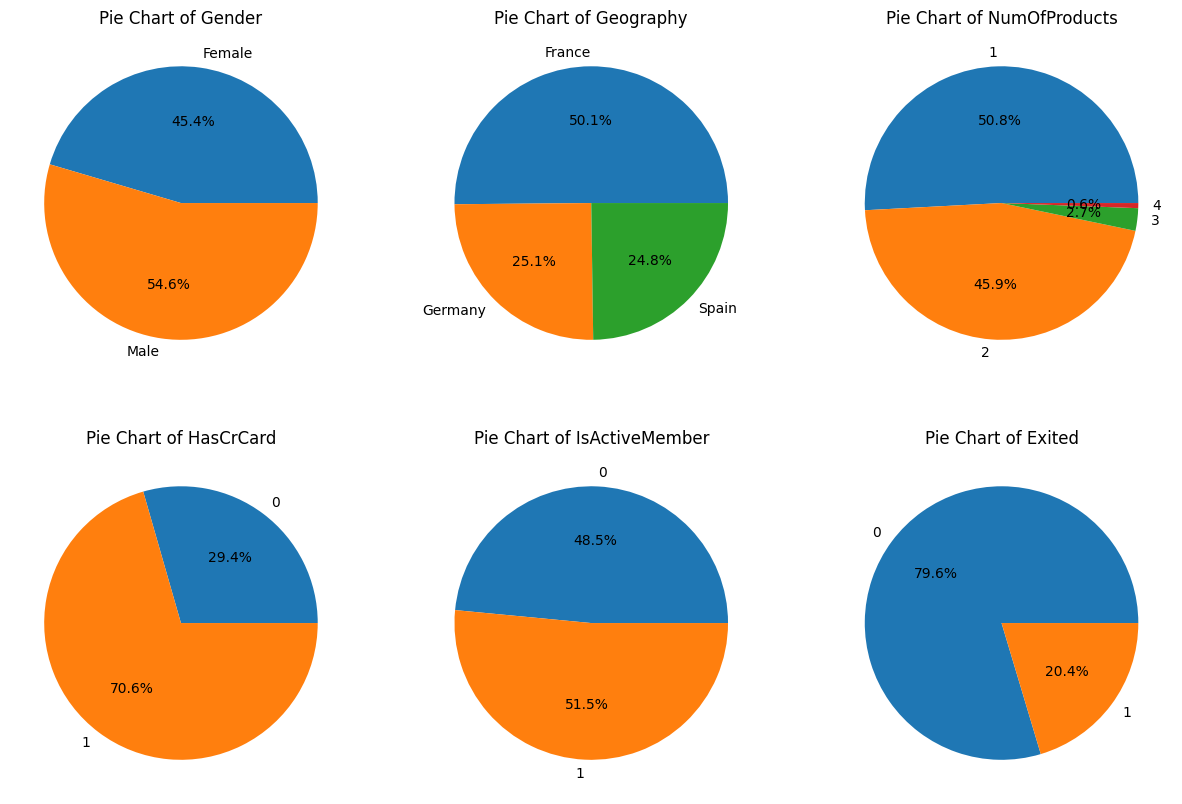

In [13]:
i = 1

plt.figure(figsize=(15,10))

for c in ["Gender", "Geography", "NumOfProducts", "HasCrCard", "IsActiveMember", "Exited"]:

    plt.subplot(2, 3, i)
    plt.pie(
        pdf[c].value_counts().sort_index(),
        labels=list(sorted(pdf[c].unique())),
        autopct="%1.1f%%"
    )
    plt.title("Pie Chart of " + c)

    i += 1

plt.show()
